In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LeakyReLU
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import sys
sys.path.insert(0, os.getcwd()+'\kernel_similarity')
sys.path.insert(0, os.getcwd()+'\concrete_autoencoder')
from kernel_sim import *
from concrete_autoencoder import *

DATA_PATH="data/measurements/merged_jetbot_data.csv"

In [14]:
df=pd.read_csv(DATA_PATH,sep=";",index_col=0)
df_temp=df[["round_nr","temp","sensor_ID"]].set_index("round_nr")
df_temp_wide=pd.pivot_table(df_temp,index="round_nr",columns="sensor_ID")
temp_array=np.array(df_temp_wide)
df_hum=df[["round_nr","hum","sensor_ID"]].set_index("round_nr")
df_hum_wide=pd.pivot_table(df_hum,index="round_nr",columns="sensor_ID")
hum_array=np.array(df_hum_wide)

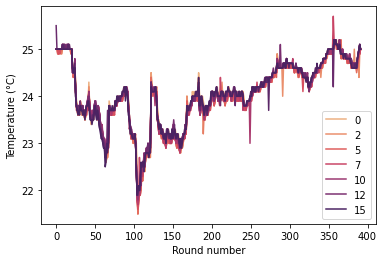

In [41]:
plt.rcParams["figure.figsize"] = (6,4)
custom_cmap = sns.color_palette("flare", as_cmap=True)
ax=sns.lineplot(data=df, x="round_nr",y="temp", hue="sensor_ID",palette=custom_cmap)
ax.set(ylabel='Temperature (°C)', xlabel="Round number")
ax.legend(loc='lower right')
fig = ax.get_figure()
fig.savefig("plots/robot_temp.pdf")

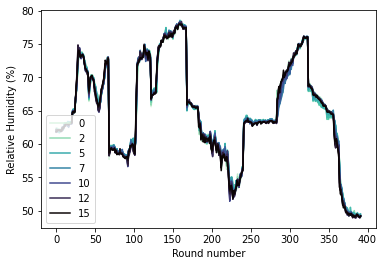

In [42]:
plt.rcParams["figure.figsize"] = (6,4)
custom_cmap = sns.color_palette("mako_r", as_cmap=True)
ax=sns.lineplot(data=df, x="round_nr",y="hum", hue="sensor_ID",palette=custom_cmap)
ax.set(ylabel='Relative Humidity (%)', xlabel="Round number")
ax.legend(loc='lower left')
fig = ax.get_figure()
fig.savefig("plots/robot_hum.pdf")

## CKA based selection

In [19]:
# Full
start = time.time()

selection, sim_sequence=select_feature_CKA(temp_array,5)

end = time.time()
for i in range(len(selection)):
    print("Sensor %d to retain: %d, with similarity: %.4f"%(i,selection[i],sim_sequence[i]))
print("total time:",(end - start))

feature 0 found
feature 1 found
feature 2 found
feature 3 found
feature 4 found
Sensor 0 to retain: 8, with similarity: 0.9895
Sensor 1 to retain: 0, with similarity: 0.9587
Sensor 2 to retain: 13, with similarity: 0.9642
Sensor 3 to retain: 2, with similarity: 0.9717
Sensor 4 to retain: 15, with similarity: 0.9706
total time: 3.079141855239868


In [20]:
# Full
start = time.time()

selection, sim_sequence=select_feature_CKA(hum_array,5)

end = time.time()
for i in range(len(selection)):
    print("Sensor %d to retain: %d, with similarity: %.4f"%(i,selection[i],sim_sequence[i]))
print("total time:",(end - start))

feature 0 found
feature 1 found
feature 2 found
feature 3 found
feature 4 found
Sensor 0 to retain: 10, with similarity: 0.9963
Sensor 1 to retain: 0, with similarity: 0.9828
Sensor 2 to retain: 15, with similarity: 0.9885
Sensor 3 to retain: 4, with similarity: 0.9885
Sensor 4 to retain: 7, with similarity: 0.9912
total time: 2.985123872756958


In [43]:
sim_matrix=np.empty([16,16])
sim_matrix.fill(1)
for i in range(16):
    for j in range(i+1,16):
        sim=CKA(temp_array[:,i],temp_array[:,j],False)
        sim_matrix[i,j]=sim
        sim_matrix[j,i]=sim
end = time.time()

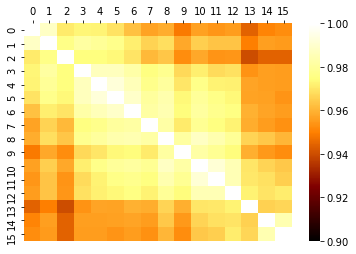

In [44]:
custom_cmap = cm.afmhot
#custom_cmap.set_bad(color='gray')
fig, ax = plt.subplots()
im=sns.heatmap(sim_matrix,cmap=custom_cmap,xticklabels=list(range(16)),yticklabels=list(range(16)),vmin=0.9, vmax=1)
#fig.colorbar(im, ax=ax)
ax.xaxis.tick_top()
plt.savefig("plots/temp_sim_heatmap.pdf")

In [45]:
sim_matrix=np.empty([16,16])
sim_matrix.fill(1)
for i in range(16):
    for j in range(i+1,16):
        sim=CKA(hum_array[:,i],hum_array[:,j],False)
        sim_matrix[i,j]=sim
        sim_matrix[j,i]=sim
end = time.time()

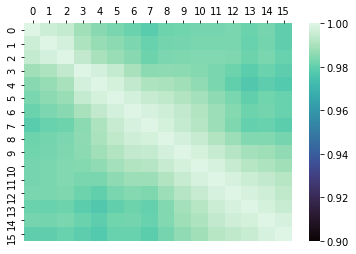

In [46]:
custom_cmap = sns.color_palette("mako", as_cmap=True)
#custom_cmap.set_bad(color='gray')
fig, ax = plt.subplots()
im=sns.heatmap(sim_matrix,cmap=custom_cmap,xticklabels=list(range(16)),yticklabels=list(range(16)),vmin=0.9, vmax=1)
#fig.colorbar(im, ax=ax)
ax.xaxis.tick_top()
plt.savefig("plots/hum_sim_heatmap.pdf")

## Concrete autoencoder

In [24]:
def convert_data(data, step):
    X, Y = [], []
    scaler = StandardScaler()
    scaler.fit(data)
    for i in range(len(data)-step+1):
        d = i+step  
        X.append(scaler.transform(data[i:d,]))
        Y.append(data[d-1,])
    return np.array(X), np.array(Y)

### Temperature

In [25]:
X,Y=convert_data(temp_array,15)
print(temp_array.shape,X.shape,Y.shape)
X_train, X_val, Y_train, Y_val= train_test_split(X,Y, test_size=0.1, random_state=2021)
X_val, X_test, Y_val, Y_test= train_test_split(X_val,Y_val, test_size=0.25, random_state=2021)
print(X_train.shape,X_val.shape,X_test.shape)
print(Y_train.std(),Y_val.std(),Y_test.std())

(392, 16) (378, 15, 16) (378, 16)
(340, 15, 16) (28, 15, 16) (10, 15, 16)
0.6772000183370052 0.5984347941138803 0.5413582455269339


In [31]:
# LEAKY RELU IS ABSOLUTELY CRUCIAL HERE
tf.random.set_seed(
    2021
)

decoder3 = Sequential()
decoder3.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder3.add(Dropout(0.1))
decoder3.add(Dense(16))

selector3 = ConcreteAutoencoderFeatureSelector(k = 3, output_function = decoder3, num_epochs =2500, batch_size=4, tryout_limit=1, learning_rate=0.01)

tf.random.set_seed(
    2021
)
decoder2 = Sequential()
decoder2.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder2.add(Dropout(0.1))
decoder2.add(Dense(16))

selector2 = ConcreteAutoencoderFeatureSelector(k = 2, output_function = decoder2, num_epochs =2500, batch_size=4, tryout_limit=1, learning_rate=0.01)

tf.random.set_seed(
    2021
)
decoder1 = Sequential()
decoder1.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder1.add(Dropout(0.1))
decoder1.add(Dense(16))

selector1 = ConcreteAutoencoderFeatureSelector(k = 1, output_function = decoder1, num_epochs =3000, batch_size=4, tryout_limit=1, learning_rate=0.01)

In [32]:
tf.random.set_seed(
    2021
)
selector1.fit(X_train, Y_train, X_val, Y_val)

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 1)             17        
_________________________________________________________________
sequential_6 (Sequential)    (None, 16)                296       
Total params: 313
Trainable params: 312
Non-trainable params: 1
_________________________________________________________________
None


Epoch: 139 | mean max of probabilities: 0.1537 | temperature:  7.9245 | loss: 0.4025, val_loss: 0.1759

KeyboardInterrupt: 

In [ ]:
selector1.model.evaluate(X_train, Y_train)
selector1.model.evaluate(X_test, Y_test)

In [ ]:
ax=sns.barplot(x=list(range(16)),y=selector1.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector1.get_mask())

In [47]:
tf.random.set_seed(
    2021
)
selector2.fit(X_train, Y_train, X_val, Y_val)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 2)             33        
_________________________________________________________________
sequential_5 (Sequential)    (None, 16)                306       
Total params: 339
Trainable params: 338
Non-trainable params: 1
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Epoch: 2499 | mean max of probabilities: 0.9759 | temperature:  0.1000 | loss: 0.0867, val_loss: 0.0838

New best converged model | loss: 0.0863, val_loss: 0.0926
New best converged model | loss: 0.0898, val_loss: 0.0807
New best converged model | loss: 0.0860, val_loss: 0.0687
New best converged model | loss: 0.0902, val_loss: 0.0630
New best converged model | loss: 0.0909, val_loss: 0.0629
New best converged model | loss: 0.0847, val_loss: 0.0605
Restoring best converged model | loss: 0.0847, val_loss: 0.0605


In [48]:
selector2.model.evaluate(X_train, Y_train)
selector2.model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.0573


0.05731060355901718

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


<ipython-input-49-a5108d01ece3>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,None,None,None,1,None,None,None,2])


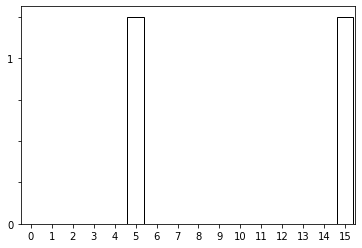

In [49]:
ax=sns.barplot(x=list(range(16)),y=selector2.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector2.get_mask())

In [50]:
tf.random.set_seed(
    2021
)
selector3.fit(X_train, Y_train, X_val, Y_val)

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 3)             49        
_________________________________________________________________
sequential_4 (Sequential)    (None, 16)                316       
Total params: 365
Trainable params: 364
Non-trainable params: 1
_________________________________________________________________
None


Epoch: 2499 | mean max of probabilities: 0.9954 | temperature:  0.1000 | loss: 0.0908, val_loss: 0.0739

New best converged model | loss: 0.0829, val_loss: 0.0945
New best converged model | loss: 0.0863, val_loss: 0.0814
New best converged model | loss: 0.0908, val_loss: 0.0706
New best converged model | loss: 0.0852, val_loss: 0.0613
New best converged model | loss: 0.0868, val_loss: 0.0582
New best converged model | loss: 0.0853, val_loss: 0.0578
New best converged model | loss: 0.0857, val_loss: 0.0571
New best converged model | loss: 0.0830, val_loss: 0.0565
New best converged model | loss: 0.0884, val_loss: 0.0561
New best converged model | loss: 0.0878, val_loss: 0.0548
Restoring best converged model | loss: 0.0878, val_loss: 0.0548


In [51]:
selector3.model.evaluate(X_train, Y_train)
selector3.model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0574


0.05739859491586685

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


<ipython-input-52-cdeef34b28ca>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,None,None,None,1,None,None,None,2])


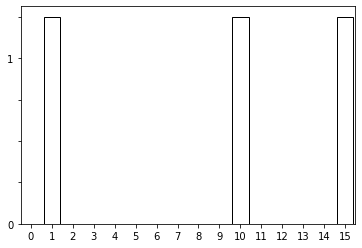

In [52]:
ax=sns.barplot(x=list(range(16)),y=selector3.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector3.get_mask())

### Humidity

In [53]:
X,Y=convert_data(hum_array,15)
print(temp_array.shape,X.shape,Y.shape)
X_train, X_val, Y_train, Y_val= train_test_split(X,Y, test_size=0.1, random_state=2021)
X_val, X_test, Y_val, Y_test= train_test_split(X_val,Y_val, test_size=0.25, random_state=2021)
print(X_train.shape,X_val.shape,X_test.shape)
print(Y_train.std(),Y_val.std(),Y_test.std())

(392, 16) (378, 15, 16) (378, 16)
(340, 15, 16) (28, 15, 16) (10, 15, 16)
7.438667560867242 8.346227821217814 7.361786653685027


In [54]:
# LEAKY RELU IS ABSOLUTELY CRUCIAL HERE
tf.random.set_seed(
    2021
)

decoder3 = Sequential()
decoder3.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder3.add(Dropout(0.1))
decoder3.add(Dense(16))

selector3 = ConcreteAutoencoderFeatureSelector(k = 3, output_function = decoder3, num_epochs =2500, batch_size=4, tryout_limit=1, learning_rate=0.01)

tf.random.set_seed(
    2021
)
decoder2 = Sequential()
decoder2.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder2.add(Dropout(0.1))
decoder2.add(Dense(16))

selector2 = ConcreteAutoencoderFeatureSelector(k = 2, output_function = decoder2, num_epochs =2500, batch_size=4, tryout_limit=1, learning_rate=0.01)

tf.random.set_seed(
    2021
)
decoder1 = Sequential()
decoder1.add(SimpleRNN(10,activation=LeakyReLU(0.2)))
decoder1.add(Dropout(0.1))
decoder1.add(Dense(16))

selector1 = ConcreteAutoencoderFeatureSelector(k = 1, output_function = decoder1, num_epochs =3000, batch_size=4, tryout_limit=1, learning_rate=0.01)

In [55]:
tf.random.set_seed(
    2021
)
selector1.fit(X_train, Y_train, X_val, Y_val)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 1)             17        
_________________________________________________________________
sequential_9 (Sequential)    (None, 16)                296       
Total params: 313
Trainable params: 312
Non-trainable params: 1
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Epoch: 2999 | mean max of probabilities: 0.9915 | temperature:  0.1000 | loss: 0.7651, val_loss: 0.4728

New best converged model | loss: 0.7441, val_loss: 0.5283
New best converged model | loss: 0.7626, val_loss: 0.4968
New best converged model | loss: 0.7120, val_loss: 0.4827
New best converged model | loss: 0.7601, val_loss: 0.4250
New best converged model | loss: 0.7616, val_loss: 0.4185
New best converged model | loss: 0.7011, val_loss: 0.4092
New best converged model | loss: 0.7437, val_loss: 0.4062
Restoring best converged model | loss: 0.7437, val_loss: 0.4062


In [56]:
selector1.model.evaluate(X_train, Y_train)
selector1.model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.3835


0.3835334777832031

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<ipython-input-57-135fc96b6055>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,None,None,None,1,None,None,None,2])


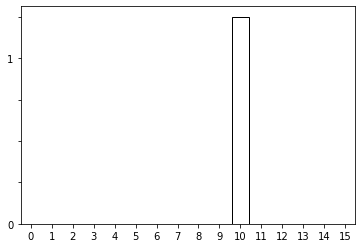

In [57]:
ax=sns.barplot(x=list(range(16)),y=selector1.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector1.get_mask())

In [58]:
tf.random.set_seed(
    2021
)
selector2.fit(X_train, Y_train, X_val, Y_val)

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 2)             33        
_________________________________________________________________
sequential_8 (Sequential)    (None, 16)                306       
Total params: 339
Trainable params: 338
Non-trainable params: 1
_________________________________________________________________
None


Epoch: 2499 | mean max of probabilities: 0.9956 | temperature:  0.1000 | loss: 0.7195, val_loss: 0.5953

New best converged model | loss: 0.7743, val_loss: 0.6873
New best converged model | loss: 0.7118, val_loss: 0.4580
New best converged model | loss: 0.7034, val_loss: 0.4076
New best converged model | loss: 0.6905, val_loss: 0.3990
New best converged model | loss: 0.7224, val_loss: 0.3684
Restoring best converged model | loss: 0.7224, val_loss: 0.3684


In [59]:
selector2.model.evaluate(X_train, Y_train)
selector2.model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 22ms/step - loss: 0.3175


0.31747302412986755

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<ipython-input-60-a5108d01ece3>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,None,None,None,1,None,None,None,2])


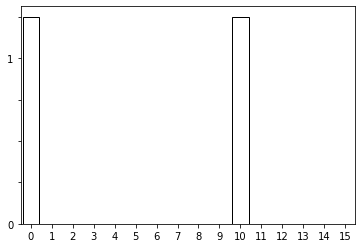

In [60]:
ax=sns.barplot(x=list(range(16)),y=selector2.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector2.get_mask())

In [61]:
tf.random.set_seed(
    2021
)
selector3.fit(X_train, Y_train, X_val, Y_val)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
concrete_select (ConcreteSel (None, 15, 3)             49        
_________________________________________________________________
sequential_7 (Sequential)    (None, 16)                316       
Total params: 365
Trainable params: 364
Non-trainable params: 1
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Epoch: 2499 | mean max of probabilities: 0.9998 | temperature:  0.1000 | loss: 0.7175, val_loss: 0.4125

New best converged model | loss: 0.7510, val_loss: 0.6206
New best converged model | loss: 0.7190, val_loss: 0.5753
New best converged model | loss: 0.7508, val_loss: 0.4913
New best converged model | loss: 0.7336, val_loss: 0.3708
New best converged model | loss: 0.7278, val_loss: 0.3314
New best converged model | loss: 0.7000, val_loss: 0.3252
New best converged model | loss: 0.6482, val_loss: 0.3204
New best converged model | loss: 0.6887, val_loss: 0.3176
New best converged model | loss: 0.6880, val_loss: 0.3057
Restoring best converged model | loss: 0.6880, val_loss: 0.3057


In [62]:
selector3.model.evaluate(X_train, Y_train)
selector3.model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.3032


0.3031848967075348

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


<ipython-input-63-cdeef34b28ca>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,None,None,None,1,None,None,None,2])


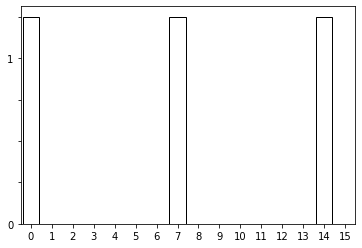

In [63]:
ax=sns.barplot(x=list(range(16)),y=selector3.get_mask(), color="white", edgecolor='black')
ax.set_yticklabels([0,None,None,None,1,None,None,None,2])
print(selector3.get_mask())